In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# matplotlib 한글 꺠짐 방지
# apt-get update
# apt-get install fonts-nanum* 
# apt-get install fontconfig
# fc-cache -fv  # font 캐시 날리기
# rm -rf /home/hy1/.cache/matplotlib/  #matplotliob 폰트 캐시 날리기


In [3]:
#!pip install matplotlib
#!pip install pandas

In [4]:
from datetime import date, datetime
from pyspark.sql.types import *
from pyspark.sql.functions import *
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt #그래프 패키지 모듈 등록
%matplotlib inline 


<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


In [5]:
def cal_std_day(befor_day):   
    x = dt.datetime.now() - dt.timedelta(befor_day)
    year = x.year
    month = x.month if x.month >= 10 else '0'+ str(x.month)
    day = x.day if x.day >= 10 else '0'+ str(x.day)  
    return str(year)+ '-' +str(month)+ '-' +str(day)

In [6]:
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':  # 맥OS 
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    rc('font', family='NanumGothic')

## Transform

### 1. 지역별 단위면적(km)당 인구수와 코로나 확진자 수의 상관관계를 구해보자

In [7]:
# 면적, 인구정보
area = spark.read.csv('/corona_data/loc/sido_area.csv', encoding='CP949', header=True)
popu = spark.read.csv('/corona_data/loc/sido_population.csv', encoding='CP949', header=True)

area.show(3)
popu.show(3)

NameError: name 'spark' is not defined

In [8]:
sc

''

In [10]:

area_popu = area.join(popu, on='loc')
#area_popu.show()

#popu_density : 면적당 인구수 : 인구 밀집도
area_popu = area_popu.select(area_popu.loc, ceil((area_popu.total/area_popu.area)).alias('popu_density'))
area_popu.show()


+----+------------+
| loc|popu_density|
+----+------------+
|서울|       16093|
|부산|        4411|
|대구|        2733|
|인천|        2831|
|광주|        2920|
|대전|        2722|
|울산|        1072|
|세종|         811|
|경기|        1366|
|강원|          93|
|충북|         221|
|충남|         265|
|전북|         226|
|전남|         152|
|경북|         141|
|경남|         321|
|제주|         378|
+----+------------+



In [11]:
# 코로나 감염자 데이터 가져오기
file_name = '/corona_data/patient/corona_patient_' + cal_std_day(2) + '.json'
tmp = spark.read.json(file_name, encoding='UTF-8')
tmp.show(3)


+--------------------+---------+------+----------+--------------+----------+
|               items|numOfRows|pageNo|resultCode|     resultMsg|totalCount|
+--------------------+---------+------+----------+--------------+----------+
|[{1465, 1461477, ...|      500|     1|        00|NORMAL SERVICE|     19722|
+--------------------+---------+------+----------+--------------+----------+



In [15]:
# 첫번째 컬럼의 값에 row가 있음
tmp.select('items').first()

Row(items=[Row(deathCnt='1465', defCnt='1461477', gubun='경남', gubunCn='庆南', gubunEn='Gyeongsangnam-do', incDec='5884', isolClearCnt='0', isolIngCnt='0', localOccCnt='5867', overFlowCnt='17', qurRate='44098', stdDay='2022-09-14'), Row(deathCnt='637', defCnt='715090', gubun='광주', gubunCn='光州', gubunEn='Gwangju', incDec='2532', isolClearCnt='0', isolIngCnt='0', localOccCnt='2519', overFlowCnt='13', qurRate='49604', stdDay='2022-09-14'), Row(deathCnt='6963', defCnt='6495551', gubun='경기', gubunCn='京畿', gubunEn='Gyeonggi-do', incDec='26133', isolClearCnt='0', isolIngCnt='0', localOccCnt='26110', overFlowCnt='23', qurRate='47883', stdDay='2022-09-14'), Row(deathCnt='1605', defCnt='1089380', gubun='경북', gubunCn='庆北', gubunEn='Gyeongsangbuk-do', incDec='4329', isolClearCnt='0', isolIngCnt='0', localOccCnt='4306', overFlowCnt='23', qurRate='41475', stdDay='2022-09-14'), Row(deathCnt='637', defCnt='715090', gubun='광주', gubunCn='光州', gubunEn='Gwangju', incDec='2532', isolClearCnt='0', isolIngCnt='

In [12]:
# 지역명과, 10만명 당 감염 현황
tmp2 = tmp.select('items').first()
co_patient = spark.createDataFrame(tmp2['items'])
co_patient.show(3)

tmp3 = co_patient.select(co_patient.gubun.alias('loc'), co_patient.qurRate)
tmp3.show(3)
co_rate = area_popu.join(tmp3, on='loc').distinct().orderBy(col('loc'))
co_rate.show()



+--------+-------+-----+-------+----------------+------+------------+----------+-----------+-----------+-------+----------+
|deathCnt| defCnt|gubun|gubunCn|         gubunEn|incDec|isolClearCnt|isolIngCnt|localOccCnt|overFlowCnt|qurRate|    stdDay|
+--------+-------+-----+-------+----------------+------+------------+----------+-----------+-----------+-------+----------+
|    1465|1461477| 경남|   庆南|Gyeongsangnam-do|  5884|           0|         0|       5867|         17|  44098|2022-09-14|
|     637| 715090| 광주|   光州|         Gwangju|  2532|           0|         0|       2519|         13|  49604|2022-09-14|
|    6963|6495551| 경기|   京畿|     Gyeonggi-do| 26133|           0|         0|      26110|         23|  47883|2022-09-14|
+--------+-------+-----+-------+----------------+------+------------+----------+-----------+-----------+-------+----------+
only showing top 3 rows

+----+-------+
| loc|qurRate|
+----+-------+
|경남|  44098|
|광주|  49604|
|경기|  47883|
+----+-------+
only showing top 3 r

+----+------------+-------+
| loc|popu_density|qurRate|
+----+------------+-------+
|강원|          93|  45979|
|경기|        1366|  47883|
|경남|         321|  44098|
|경북|         141|  41475|
|광주|        2920|  49604|
|대구|        2733|  43971|
|대전|        2722|  48307|
|부산|        4411|  43180|
|서울|       16093|  49673|
|세종|         811|  50913|
|울산|        1072|  46618|
|인천|        2831|  47227|
|전남|         152|  43984|
|전북|         226|  45901|
|제주|         378|  48672|
|충남|         265|  45963|
|충북|         221|  47313|
+----+------------+-------+



<AxesSubplot:xlabel='popu_density', ylabel='qurRate'>

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


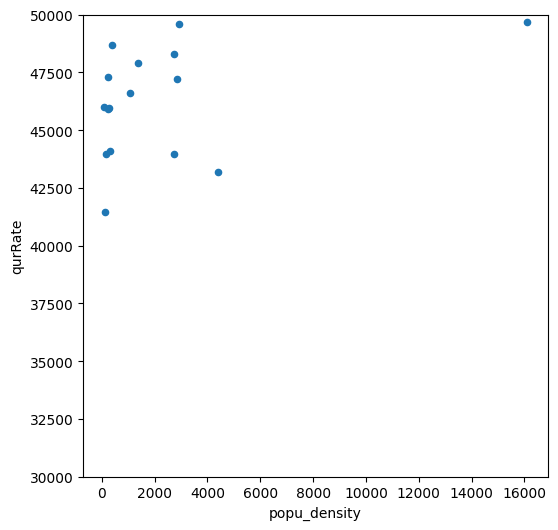

In [16]:
pd_co = co_rate.toPandas()
pd_co['qurRate'] = pd_co['qurRate'].astype(int)
# pd_co.plot(kind='scatter'
#            ,x='popu_density'
#            ,y='qurRate'
#            ,ylim=(30000,50000)
#            ,figsize=(6, 6)
#           )


### 2.  4차 예방접종 완료자와 코로나 확진자 수의 상관관계를 구해보자

In [27]:
file_name = '/corona_data/vaccine/corona_vaccine_' + cal_std_day(1) + '.json'
vaccine = spark.read.json(file_name)
#vaccine.show(3)
vaccine_df = spark.createDataFrame(vaccine.select('data').first()['data'])
#vaccine_df.show()

pop_vaccine = vaccine_df.join(popu, on='loc').select('loc', col('v4'), col('total'),
                                                     ceil(
                                                         (col('v4')/col('total')) * 100
                                                     ).alias('v_rate'))
pop_vaccine.show(100)
tmp3 = co_patient.select(co_patient.gubun.alias('loc'), co_patient.qurRate)

co_vaccine_df = pop_vaccine.join(tmp3, on ='loc')
co_vaccine_df = co_vaccine_df.select('loc','v_rate','qurRate').distinct()
co_vaccine_df.show()

+----+-------+---------+------+
| loc|     v4|    total|v_rate|
+----+-------+---------+------+
|서울|1226070| 9736027 |    13|
|부산| 488630| 3396109 |    15|
|대구| 259429| 2412642 |    11|
|인천| 394343| 3014739 |    14|
|광주| 233610| 1462545 |    16|
|대전| 193191| 1469543 |    14|
|울산| 124886| 1138419 |    11|
|세종|  34585|  376779 |    10|
|경기|1680362|13925862 |    13|
|강원| 269222| 1555876 |    18|
|충북| 277332| 1633472 |    17|
|충남| 365655| 2181835 |    17|
|전북| 370187| 1817186 |    21|
|전남| 444061| 1865459 |    24|
|경북| 394769| 2677709 |    15|
|경남| 483703| 3377331 |    15|
|제주|  92009|  697476 |    14|
+----+-------+---------+------+

+----+------+-------+
| loc|v_rate|qurRate|
+----+------+-------+
|강원|    18|  45979|
|경기|    13|  47883|
|경남|    15|  44098|
|경북|    15|  41475|
|광주|    16|  49604|
|대구|    11|  43971|
|대전|    14|  48307|
|부산|    15|  43180|
|서울|    13|  49673|
|세종|    10|  50913|
|울산|    11|  46618|
|인천|    14|  47227|
|전남|    24|  43984|
|전북|    21|  45901|
|제주|    14|  48

### 3. 다중이용시설과 코로나 확진자 수의 상관관계

MapPartitionsRDD[924] at javaToPython at <unknown>:0


+----+--------+-------+
| loc|fac_popu|qurRate|
+----+--------+-------+
|경북|      36|  34789|
|대전|      53|  41017|
|전북|      42|  38925|
|충북|      38|  40338|
|울산|      38|  40562|
|경남|      41|  37690|
|제주|      45|  42605|
|충남|      38|  39130|
|전남|      45|  36958|
|인천|      46|  41435|
|부산|      44|  37579|
|대구|      43|  36677|
|경기|      46|  41938|
|서울|      54|  44168|
|광주|      51|  42137|
|세종|      65|  43412|
|강원|      38|  39566|
+----+--------+-------+



### 4. 요일별 코로나 확진자 수를 구해보자

+-----------+---------+
|day_of_week| patients|
+-----------+---------+
|          1|3730348.0|
|          2|2381642.0|
|          3|5038466.0|
|          4|6983162.0|
|          5|5646140.0|
|          6|4312480.0|
|          7|4161302.0|
+-----------+---------+

